Summary of this case:
1. features dataset seem to have all the weeks we need for analysis. So try to merge data with that in mind before imputation. 

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import STL
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio

In [68]:
stores = pd.read_csv('stores.csv')
train_sales = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
features = pd.read_csv('features.csv')

### Merged Data

In [69]:
df_join = train_sales.groupby(["Store","Dept"]).sum(1).reset_index()[["Store","Dept"]].merge(features, on = ["Store"], how="right").merge(train_sales.drop(columns="IsHoliday"), on = ["Store","Dept","Date"], how="left")
df_join

,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales
0,1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,24924.50
1,1,2,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,50605.27
2,1,3,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,13740.12
3,1,4,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,39954.04
4,1,5,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,32229.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606237,45,94,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False,NaN
606238,45,95,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False,NaN
606239,45,96,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False,NaN
606240,45,97,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False,NaN


In [70]:
# drop date greater than max date in train data
max_date = np.max(train_sales.Date)
print(max_date)
df_join = df_join[df_join["Date"]<=max_date].reset_index(drop=True)
print(df_join.shape)
df_join.head(2)

2012-10-26
(476333, 14)


,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales
0,1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,24924.50
1,1,2,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,50605.27


In [18]:
df_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476333 entries, 0 to 476332
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         476333 non-null  int64  
 1   Dept          476333 non-null  int64  
 2   Date          476333 non-null  object 
 3   Temperature   476333 non-null  float64
 4   Fuel_Price    476333 non-null  float64
 5   MarkDown1     168943 non-null  float64
 6   MarkDown2     123431 non-null  float64
 7   MarkDown3     152700 non-null  float64
 8   MarkDown4     149148 non-null  float64
 9   MarkDown5     169881 non-null  float64
 10  CPI           476333 non-null  float64
 11  Unemployment  476333 non-null  float64
 12  IsHoliday     476333 non-null  bool   
 13  Weekly_Sales  421570 non-null  float64
dtypes: bool(1), float64(10), int64(2), object(1)
memory usage: 47.7+ MB


In [71]:
np.sum(df_join.isnull())

/Users/lixiaohua/anaconda3/envs/myenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Store                0
Dept                 0
Date                 0
Temperature          0
Fuel_Price           0
MarkDown1       307390
MarkDown2       352902
MarkDown3       323633
MarkDown4       327185
MarkDown5       306452
CPI                  0
Unemployment         0
IsHoliday            0
Weekly_Sales     54763
dtype: int64

In [72]:
df_join['Date'] = pd.to_datetime(df_join['Date'])
df_join.info()
# test_df['id'] = test_df['Store'].astype(str) + '_' + test_df['Dept'].astype(str) + '_' + test_df['Date'].astype(str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476333 entries, 0 to 476332
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         476333 non-null  int64         
 1   Dept          476333 non-null  int64         
 2   Date          476333 non-null  datetime64[ns]
 3   Temperature   476333 non-null  float64       
 4   Fuel_Price    476333 non-null  float64       
 5   MarkDown1     168943 non-null  float64       
 6   MarkDown2     123431 non-null  float64       
 7   MarkDown3     152700 non-null  float64       
 8   MarkDown4     149148 non-null  float64       
 9   MarkDown5     169881 non-null  float64       
 10  CPI           476333 non-null  float64       
 11  Unemployment  476333 non-null  float64       
 12  IsHoliday     476333 non-null  bool          
 13  Weekly_Sales  421570 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(10), int64(2)
memory usage: 4

In [73]:
# The plot above is too crowded, try to split the dates and look at yearly trend instead.
df_join['Year'] = df_join['Date'].dt.year
df_join['Month'] = df_join['Date'].dt.month
df_join['Week'] = df_join['Date'].dt.isocalendar().week
df_join['Day of the week'] = df_join['Date'].dt.day_name()
df_join.shape

(476333, 18)

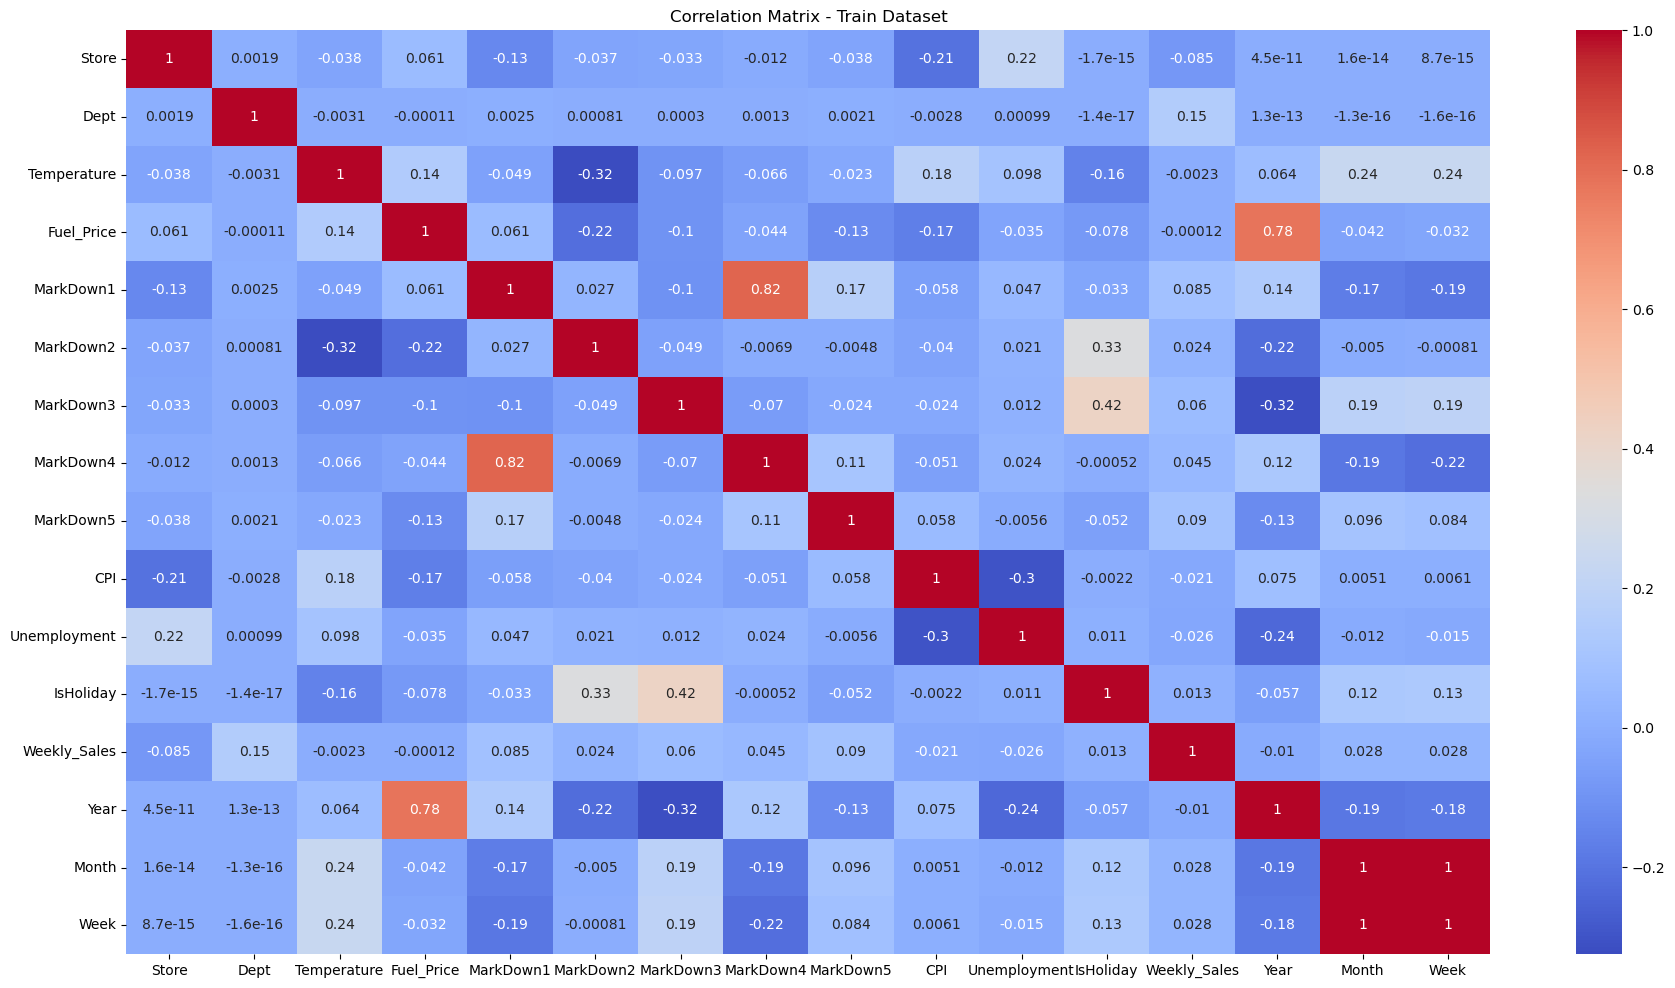

In [24]:
cor_mx= df_join.corr(numeric_only=True)
plt.figure(figsize=(22, 12))
sns.heatmap(cor_mx, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix - Train Dataset')

plt.show()

## Select Store 45 to do more analysis

In [74]:
df_store45 = df_join[(df_join['Store']==45)].reset_index(drop=True)
# df_join["Store"]==45
df_store45.shape

(10582, 18)

## Look at the plots of weekly sales over dates, obviously there are a lot of missing values.

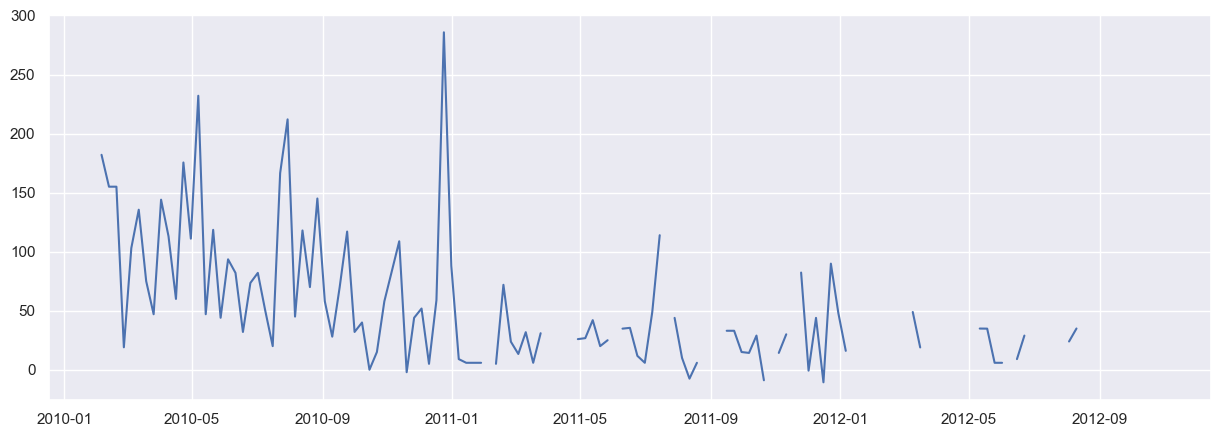

In [75]:

plt.plot(df_store45.loc[df_store45.Dept==54,"Date"], df_store45.loc[df_store45.Dept==54,"Weekly_Sales"])

In [76]:
missing_indices = df_store45.loc[df_store45.Dept==54,"Weekly_Sales"].isnull()
missing_indices

46       False
120      False
194      False
268      False
342      False
         ...  
10258     True
10332    False
10406     True
10480     True
10554    False
Name: Weekly_Sales, Length: 143, dtype: bool

# Imputation

## 1. Filling missing values with median

In [77]:
df_join_copy1 = df_join.copy()
df_join_copy1.shape

(476333, 18)

In [78]:
df_median = df_join_copy1.groupby(["Store", "Dept"])["Weekly_Sales"].median().reset_index()
df_median.columns = ["Store","Dept","Weekly_Sales_to_fill"]
df_median

,Store,Dept,Weekly_Sales_to_fill
0,1,1,18535.480
1,1,2,45561.850
2,1,3,10366.850
3,1,4,36579.960
4,1,5,21183.420
...,...,...,...
3326,45,94,4120.155
3327,45,95,52417.470
3328,45,96,2.970
3329,45,97,6470.520


In [79]:
df_join_copy1 = df_join_copy1.merge(df_median, on = ["Store", "Dept"])
df_join_copy1.shape

(476333, 19)

In [80]:
df_join_copy1.loc[df_join_copy1["Weekly_Sales"].isnull(),"Weekly_Sales"] = df_join_copy1.loc[df_join_copy1["Weekly_Sales"].isnull(),"Weekly_Sales_to_fill"]

In [81]:
np.sum(df_join_copy1.isnull())

/Users/lixiaohua/anaconda3/envs/myenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Store                        0
Dept                         0
Date                         0
Temperature                  0
Fuel_Price                   0
MarkDown1               307390
MarkDown2               352902
MarkDown3               323633
MarkDown4               327185
MarkDown5               306452
CPI                          0
Unemployment                 0
IsHoliday                    0
Weekly_Sales                 0
Year                         0
Month                        0
Week                         0
Day of the week              0
Weekly_Sales_to_fill         0
dtype: int64

### After filling out missing values, look at the same plot again

In [82]:
df_store45 = df_join_copy1[(df_join_copy1['Store']==45)]

In [83]:
np.sum(df_store45.isnull())

Store                      0
Dept                       0
Date                       0
Temperature                0
Fuel_Price                 0
MarkDown1               6808
MarkDown2               7474
MarkDown3               6956
MarkDown4               6808
MarkDown5               6808
CPI                        0
Unemployment               0
IsHoliday                  0
Weekly_Sales               0
Year                       0
Month                      0
Week                       0
Day of the week            0
Weekly_Sales_to_fill       0
dtype: int64

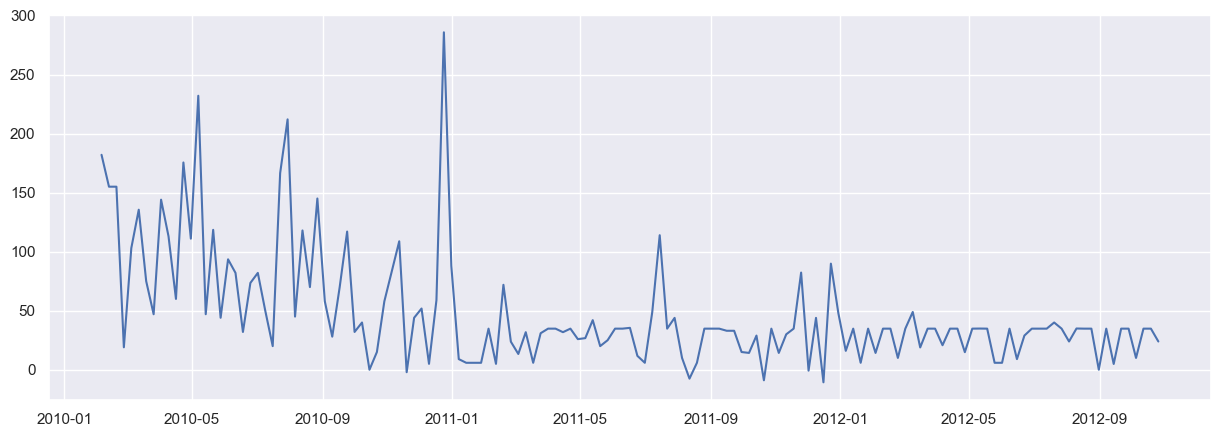

In [84]:
plt.plot(df_store45.loc[df_store45.Dept==54,"Date"], df_store45.loc[df_store45.Dept==54,"Weekly_Sales"])

### 2. Last Observation Carried Forward (LOCF) - Forward Fill missing values
Same method applies if we use backward fill bfill()

In [85]:
df_join_copy2 = df_join.copy()
df_join_copy2

,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales,Year,Month,Week,Day of the week
0,1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,24924.50,2010,2,5,Friday
1,1,2,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,50605.27,2010,2,5,Friday
2,1,3,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,13740.12,2010,2,5,Friday
3,1,4,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,39954.04,2010,2,5,Friday
4,1,5,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,32229.38,2010,2,5,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476328,45,94,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,5203.31,2012,10,43,Friday
476329,45,95,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,56017.47,2012,10,43,Friday
476330,45,96,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,NaN,2012,10,43,Friday
476331,45,97,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,6817.48,2012,10,43,Friday


In [86]:
# Apply ffill within each group but keep the DataFrame structure intact
df_join_copy2['Weekly_Sales'] = df_join_copy2.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.ffill())

# Now df_join_copy2 contains the original data along with the forward-filled 'Weekly_Sales'
df_join_copy2

,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales,Year,Month,Week,Day of the week
0,1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,24924.50,2010,2,5,Friday
1,1,2,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,50605.27,2010,2,5,Friday
2,1,3,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,13740.12,2010,2,5,Friday
3,1,4,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,39954.04,2010,2,5,Friday
4,1,5,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,32229.38,2010,2,5,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476328,45,94,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,5203.31,2012,10,43,Friday
476329,45,95,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,56017.47,2012,10,43,Friday
476330,45,96,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,2.94,2012,10,43,Friday
476331,45,97,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,6817.48,2012,10,43,Friday


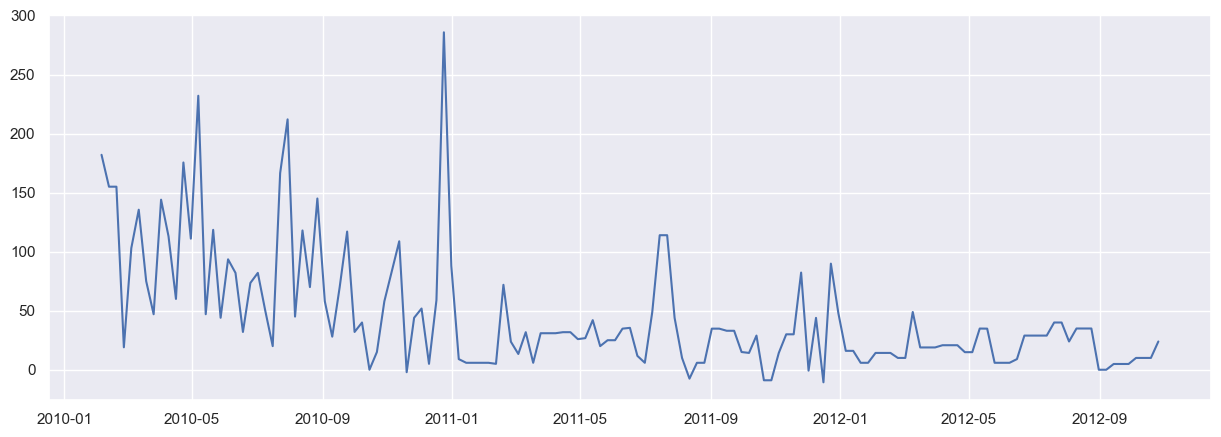

In [87]:
df_store45 = df_join_copy2[(df_join_copy2['Store']==45)]
plt.plot(df_store45.loc[df_store45.Dept==54,"Date"], df_store45.loc[df_store45.Dept==54,"Weekly_Sales"])

### Prophet Model
Use the dataset copy with median fill method imputation

In [62]:
import prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [103]:
df_join_copy1 = df_join_copy1.fillna(0)
df_join_copy1.head(2)

,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales,Year,Month,Week,Day of the week,Weekly_Sales_to_fill
0,1,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,24924.50,2010,2,5,Friday,18535.48
1,1,2,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,50605.27,2010,2,5,Friday,45561.85


In [104]:
np.sum(df_join_copy1.isnull())

/Users/lixiaohua/anaconda3/envs/myenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Store                   0
Dept                    0
Date                    0
Temperature             0
Fuel_Price              0
MarkDown1               0
MarkDown2               0
MarkDown3               0
MarkDown4               0
MarkDown5               0
CPI                     0
Unemployment            0
IsHoliday               0
Weekly_Sales            0
Year                    0
Month                   0
Week                    0
Day of the week         0
Weekly_Sales_to_fill    0
dtype: int64

In [105]:
# Find the 105th week
date = list(df_join_copy1["Date"].value_counts().keys())
date.sort()
date[104]

Timestamp('2012-02-03 00:00:00')

In [106]:
# use 2012-02-03 to 2012-11-01 as test data
train_df = df_join_copy1[df_join_copy1["Date"]<date[104]].reset_index(drop=True)
print(train_df.shape)
train_df.head(2)

(346424, 19)


,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales,Year,Month,Week,Day of the week,Weekly_Sales_to_fill
0,1,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,24924.50,2010,2,5,Friday,18535.48
1,1,2,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,50605.27,2010,2,5,Friday,45561.85


In [107]:
test_df = df_join_copy1[df_join_copy1["Date"]>=date[104]].reset_index(drop=True)
print(test_df.shape)
test_df.head(2)

(129909, 19)


,Store,Dept,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales,Year,Month,Week,Day of the week,Weekly_Sales_to_fill
0,1,1,2012-02-03,56.55,3.36,34577.06,3579.21,160.53,32403.87,5630.4,220.172015,7.348,False,23510.49,2012,2,5,Friday,18535.48
1,1,2,2012-02-03,56.55,3.36,34577.06,3579.21,160.53,32403.87,5630.4,220.172015,7.348,False,54322.24,2012,2,5,Friday,45561.85


In [108]:
train_df.rename(columns={'Date':'ds', 'Weekly_Sales':'y'}, inplace=True)
train_df.head()

,Store,Dept,ds,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,y,Year,Month,Week,Day of the week,Weekly_Sales_to_fill
0,1,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,24924.50,2010,2,5,Friday,18535.48
1,1,2,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,50605.27,2010,2,5,Friday,45561.85
2,1,3,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,13740.12,2010,2,5,Friday,10366.85
3,1,4,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,39954.04,2010,2,5,Friday,36579.96
4,1,5,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,32229.38,2010,2,5,Friday,21183.42


In [118]:
train_df.columns

Index(['Store', 'Dept', 'ds', 'Temperature', 'Fuel_Price', 'MarkDown1',
       'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'IsHoliday', 'y', 'Year', 'Month', 'Week',
       'Day of the week', 'Weekly_Sales_to_fill'],
      dtype='object')

In [121]:
for ds in train_df.keys():
    # make holidays more specific
    # Define the holiday based on specific conditions
    mask_super_bowl = (train_df[ds]['IsHoliday'] == True) & (train_df[ds]['Date'].dt.month == 2)
    mask_labor_day = (train_df[ds]['IsHoliday'] == True) & (train_df[ds]['Date'].dt.month == 9)
    mask_thanksgiving = (train_df[ds]['IsHoliday'] == True) & (train_df[ds]['Date'].dt.month == 11)
    mask_christmas = (train_df[ds]['IsHoliday'] == True) & (train_df[ds]['Date'].dt.month == 12)

    # Apply the conditions
    train_df[ds].loc[mask_super_bowl, 'Holiday_Type'] = 'Super_Bowl'
    train_df[ds].loc[mask_labor_day, 'Holiday_Type'] = 'Labor_Day'
    train_df[ds].loc[mask_thanksgiving, 'Holiday_Type'] = 'Thanksgiving'
    train_df[ds].loc[mask_christmas, 'Holiday_Type'] = 'Christmas'
    train_df[ds].drop(columns=['IsHoliday'], inplace=True)
    
    # 1-hot encoding for categorical features
    train_df[ds] = pd.get_dummies(train_df[ds], columns=["Type", "Holiday_Type"])
    
    # data imputation
    train_df[ds].fillna(value=0, inplace=True)
    display(train_df[ds].head())

KeyError: 'IsHoliday'

In [ ]:
# X = df_join_copy1[['Year','Month','Week','Day of the week']]
# y = df_join_copy1[['Weekly_Sales']]
# features_and_target = pd.concat([X, y], axis=1)
# features_and_target

In [111]:
holidays = pd.DataFrame({
    'holiday': ['Super_Bowl']*4 + ['Labor_Day']*4 + ['Thanksgiving']*4 + ['Christmas']*4,
    'ds': pd.to_datetime(['12-02-2010', '11-02-2011', '10-02-2012', '08-02-2013',
                          '10-09-2010', '09-09-2011', '07-09-2012', '06-09-2013',
                          '26-10-2010', '25-10-2011', '23-10-2012', '29-10-2013',
                          '31-12-2010', '30-12-2011', '28-12-2012', '27-12-2013',]),
    'lower_window': 0,
    'upper_window': 1,
})

ValueError: time data "26-10-2010" doesn't match format "%m-%d-%Y", at position 8. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [110]:
STORE_ID = 44
Models = dict()

for name, group in train_df.groupby(["Store", "Dept"]):
    
    if name[0] != STORE_ID:
        continue
        
    data_grouped = group.drop(columns=["Store", "Dept"])
    print(f"\n Training Facebook's Prophet for store={name[0]}, dept={name[1]} with {len(data_grouped)} samples ...")
    
    if len(data_grouped) < 3:
        print(f"\t\t Number of samples must be larger than 2 !!!")
        Models[name] = [None, np.mean(group['y'])]
        continue
    
    model = prophet(
        growth='linear', # linear or logistic
        changepoints=None, # list of dates at which to include potential changepoints
        n_changepoints=11, # number of potential changepoints
        changepoint_range=0.69, # proportion of history in which trend changepoints will be estimated
        yearly_seasonality='auto',
        weekly_seasonality='auto',
        daily_seasonality='auto',
        holidays=holidays,
        seasonality_mode='additive',
        seasonality_prior_scale=6.9,
        holidays_prior_scale=6.9,
        changepoint_prior_scale=0.169,
        mcmc_samples=0, # if > 0: Bayesian inference with number of MCMC samples, else: MAP estimation
        interval_width=0.69, # width of the uncertainty intervals provided for the forecast
        uncertainty_samples=690 # number of simulated draws used to estimate uncertainty intervals
    )

    for col in ['Size', 'CPI', 'Unemployment']:
        model.add_regressor(name=col, prior_scale=None, standardize='auto', mode='additive')
        
    # Training model        
    t1 = time.time()
    model.fit(data_grouped)
    t2 = time.time()
    print(f"\t\t ... in {round(t2-t1, 3)} seconds")

    Models[name] = [model, np.mean(group['y'])]



 Training Facebook's Prophet for store=44, dept=1 with 104 samples ...


NameError: name 'holidays' is not defined